In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

In [10]:
df = pd.read_csv("train.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

In [11]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

<Axes: xlabel='date'>

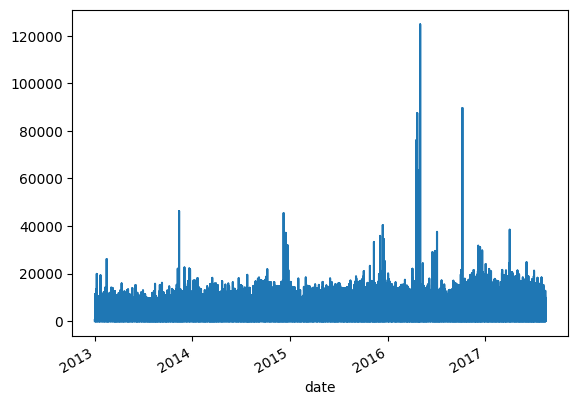

In [12]:
sales = df['sales']
sales.plot()

In [13]:
le = LabelEncoder()
df['family_idx'] = le.fit_transform(df['family'])

In [14]:
# Sort and group
df = df.sort_values(['store_nbr', 'family'])   # date order is preserved by the index

group_cols = ['store_nbr', 'family']
g = df.groupby(group_cols)['sales']          # df already has DatetimeIndex

# lags
for w in [1, 7, 14, 28, 56]:
    df[f'lag_{w}'] = g.shift(w)

# calendar-based rolling means (exclude today)
for w in ['7D', '14D']:
    name = f'rolling_{w[:-1]}_mean'
    df[name] = (
        g.apply(lambda s: s.shift(1).rolling(w).mean())
          .reset_index(level=group_cols, drop=True)
    )

In [21]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays.set_index('date', inplace=True)

In [22]:
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [23]:
unique_vals = holidays['type'].unique()
print(unique_vals)


['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


In [24]:
unique_vals = holidays['locale'].unique()
print(unique_vals)


['Local' 'Regional' 'National']


In [28]:
# 1. Boolean mask for national‐only
mask = holidays['locale'] == 'National'

# 2. Filter the DataFrame
national_holidays = holidays[mask]

# 3. Inspect the result
print(national_holidays.head())


                type    locale locale_name  \
date                                         
2012-08-10   Holiday  National     Ecuador   
2012-10-09   Holiday  National     Ecuador   
2012-10-12  Transfer  National     Ecuador   
2012-11-02   Holiday  National     Ecuador   
2012-11-03   Holiday  National     Ecuador   

                                    description  transferred  
date                                                          
2012-08-10        Primer Grito de Independencia        False  
2012-10-09           Independencia de Guayaquil         True  
2012-10-12  Traslado Independencia de Guayaquil        False  
2012-11-02                      Dia de Difuntos        False  
2012-11-03              Independencia de Cuenca        False  
